# Computer vision

In [1]:
import random
import torch

from mlxtend.plotting import plot_confusion_matrix

from torch import nn
from torch.utils.data import DataLoader

from torchmetrics import ConfusionMatrix

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
len(train_data.data), len(train_data.targets)

(60000, 60000)

In [4]:
len(test_data.data), len(test_data.targets)

(10000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

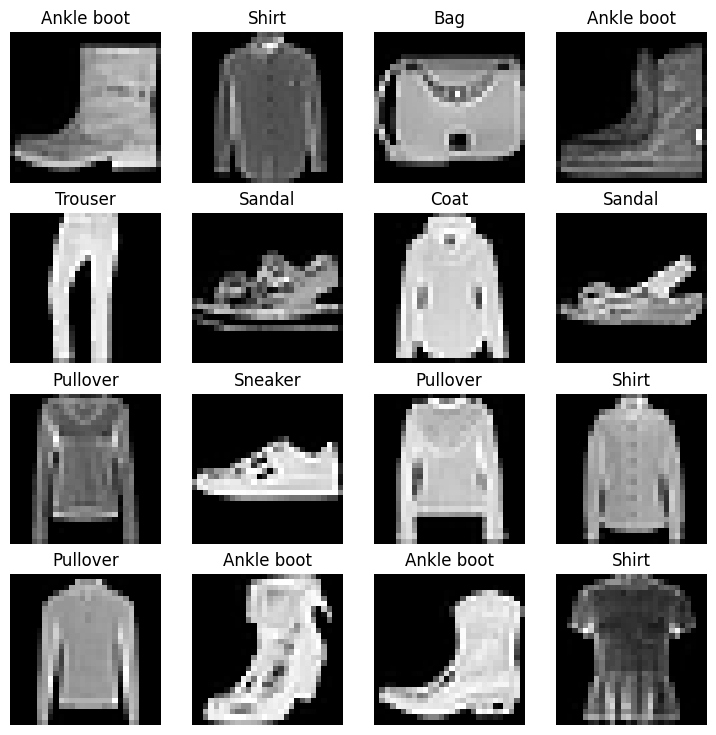

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols +1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

plt.show()

In [7]:
batch_size = 32

train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(f"Number of training batches: {len(train_data_loader)}")

test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print(f"Number of testing batches: {len(test_data_loader)}")

Number of training batches: 1875
Number of testing batches: 313


In [8]:
train_features_batch, train_labels_batch = next(iter(train_data_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Baseline model

In [9]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [10]:
class FashionMNISTModel0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [11]:
torch.manual_seed(42)
n_pixels = train_features_batch[0].shape[1] * train_features_batch[0].shape[2]

model0 = FashionMNISTModel0(input_shape=784,
                            hidden_units=10,
                            output_shape=len(class_names))
model0.to("cpu")

FashionMNISTModel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [13]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return 100 * correct / len(y_pred)

In [14]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optimiser: torch.optim.Optimizer,
               accuracy_fn):

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    return {
        "loss": train_loss / len(data_loader),
        "accuracy": train_acc / len(data_loader),
    }

In [15]:
def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_fn: nn.Module,
              accuracy_fn):
    
    test_loss, test_acc = 0, 0
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    return {
        "loss": test_loss / len(data_loader),
        "accuracy": test_acc / len(data_loader),
    }    

In [16]:
torch.manual_seed(42)

for epoch in range(3):
    print(f"Epoch {epoch}")
    training_results = train_step(model0, 
                                  train_data_loader, 
                                  loss_fn, 
                                  optimiser, 
                                  accuracy)
    print(f"Training loss: {training_results['loss']}, accuracy: {training_results['accuracy']}")

    testing_results = test_step(model0,
                                test_data_loader,
                                loss_fn,
                                accuracy)
    print(f"Training loss: {testing_results['loss']}, accuracy: {testing_results['accuracy']}")    


Epoch 0
Training loss: 0.5903891921043396, accuracy: 79.17166666666667
Training loss: 0.5095351338386536, accuracy: 82.03873801916933
Epoch 1
Training loss: 0.4763319790363312, accuracy: 83.32
Training loss: 0.47989004850387573, accuracy: 83.19688498402556
Epoch 2
Training loss: 0.4550333321094513, accuracy: 84.05166666666666
Training loss: 0.47663894295692444, accuracy: 83.42651757188499


## Model with non-linearity

In [17]:
class FashionMNISTModel1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [18]:
torch.manual_seed(42)
model1 = FashionMNISTModel1(input_shape=784,
                            hidden_units=10,
                            output_shape=len(class_names))

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [19]:
torch.manual_seed(42)

for epoch in range(3):
    print(f"Epoch {epoch}")
    training_results = train_step(model1, 
                                  train_data_loader, 
                                  loss_fn, 
                                  optimiser, 
                                  accuracy)
    print(f"Training loss: {training_results['loss']}, accuracy: {training_results['accuracy']}")

    testing_results = test_step(model1,
                                test_data_loader,
                                loss_fn,
                                accuracy)
    print(f"Training loss: {testing_results['loss']}, accuracy: {testing_results['accuracy']}")    


Epoch 0
Training loss: 1.0919920206069946, accuracy: 61.343333333333334
Training loss: 0.9563649296760559, accuracy: 64.99600638977635
Epoch 1
Training loss: 0.7810057997703552, accuracy: 71.92833333333333
Training loss: 0.7222670316696167, accuracy: 73.91174121405751
Epoch 2
Training loss: 0.6702709197998047, accuracy: 75.93666666666667
Training loss: 0.6850008964538574, accuracy: 75.01996805111821


## Convolutional Neural Network

In [20]:
class FashionMNISTModel2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

In [21]:
torch.manual_seed(42)
model2 = FashionMNISTModel2(input_shape=1,
                            hidden_units=10,
                            output_shape=len(class_names))

loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model2.parameters(), lr=0.1)


In [22]:
torch.manual_seed(42)

for epoch in range(3):
    print(f"Epoch {epoch}")
    training_results = train_step(model2, 
                                  train_data_loader, 
                                  loss_fn, 
                                  optimiser, 
                                  accuracy)
    print(f"Training loss: {training_results['loss']}, accuracy: {training_results['accuracy']}")

    testing_results = test_step(model2,
                                test_data_loader,
                                loss_fn,
                                accuracy)
    print(f"Training loss: {testing_results['loss']}, accuracy: {testing_results['accuracy']}")    


Epoch 0
Training loss: 0.5920280814170837, accuracy: 78.515
Training loss: 0.3926296532154083, accuracy: 85.91253993610223
Epoch 1
Training loss: 0.36232247948646545, accuracy: 87.04333333333334
Training loss: 0.3497513234615326, accuracy: 87.33027156549521
Epoch 2
Training loss: 0.32416149973869324, accuracy: 88.25
Training loss: 0.32895955443382263, accuracy: 88.12899361022365


## Evaluate predictions with the best model

In [23]:
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [24]:
def predict_class(sample):
    model2.eval()
    with torch.inference_mode():
        sample = torch.unsqueeze(sample, dim=0)
        pred_logit = model2(sample)
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        return pred_prob.argmax(dim=0).item()


In [25]:
preds = [predict_class(sample) for sample in test_samples]

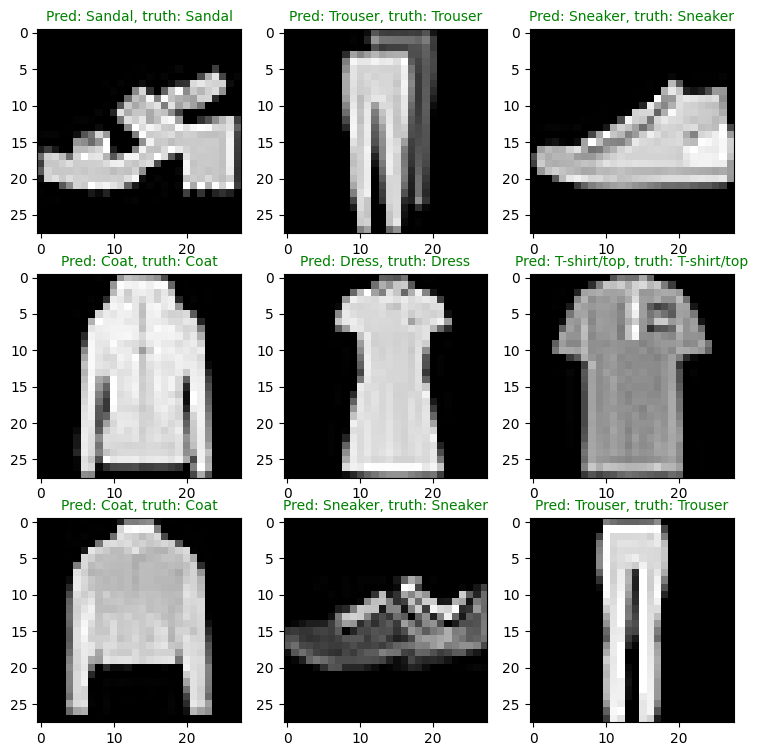

In [26]:
plt.figure(figsize=(9, 9))
n_rows, n_cols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    plt.title(f"Pred: {class_names[preds[i]]}, truth: {class_names[test_labels[i]]}",
              fontsize=10,
              color="g" if class_names[preds[i]] == class_names[test_labels[i]] else "r")

plt.show()

In [27]:
predicated_class = []
for samples, _ in test_data_loader:
    for sample in samples:
        predicated_class.append(predict_class(sample))
predicated_class = torch.Tensor(predicated_class)

In [28]:
confmat = ConfusionMatrix(num_classes=len(class_names), 
                          task='multiclass')
confmat_tensor = confmat(preds=predicated_class,
                         target=test_data.targets)

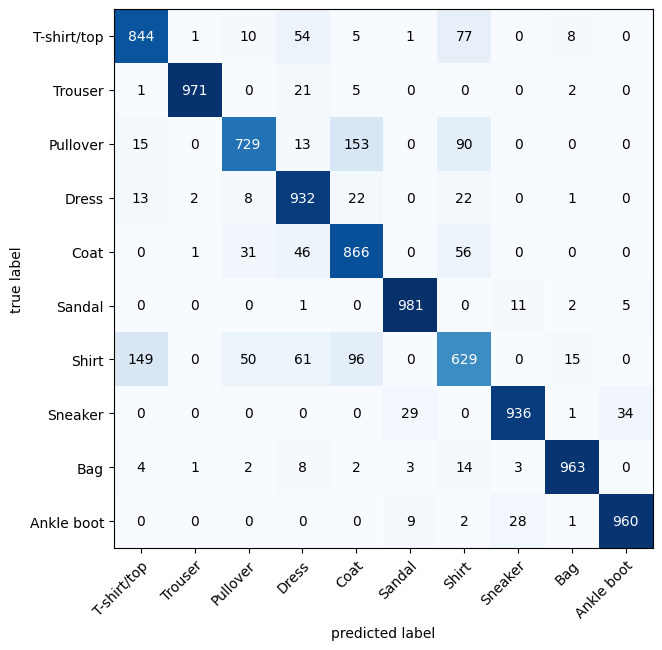

In [29]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)